In [1]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox

In [2]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        self.labels = pd.read_csv(path_to_labels_csv)
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
# Optionally applies data augmentation to the image and bounding box.
# Normalizes the image.
# Returns the image and bounding box as PyTorch tensors.

        # Load patient
        patient = self.patients[idx]
        # Extracting patient data from dataset(a single row)
        data = self.labels[self.labels['name'] == patient]
        # Extracting the coordinates
        # .item() is to get a native python type
        x_min = data['x0'].item()
        y_min = data['y0'].item()
        x_max = x_min + data['w'].item()
        y_max = y_min + data['h'].item()
        bbox = [x_min, y_min, x_max, y_max]

        # Load the image
        file_path = self.root_path / patient
        img = np.load(f'{file_path}.npy').astype(np.float32)

        # Check for augmentation
        if self.augment:
            
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            # Generating a random seed, because we want to augment both the box
            # and the image in the same way, so the box matches the heart location in image
            random_seed = torch.randint(0, 100000, (1,)).item()
            imgaug.seed(random_seed)
            
            # Augmenting image and box
            img, aug_bbox = self.augment(image=img, bounding_boxes=bb)
            # Updating coordinates for the augmented box 
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]

        # Normalizing img using mean and std calculated in Preprocessing
        img = (img - 0.494) / 0.252
        # Adding batch layer for PyTorch
        # This is often necessary because neural networks expect input in batches
        img = torch.tensor(img).unsqueeze(0)
        # Converting our list to tensor
        bbox = torch.tensor(bbox)
        return img, bbox

In [3]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
# Using imgaug for applying augmentations on bounding boxes
# Torchvision doesn't do this(applying transformation on bounding boxes)
seq = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale=(0.8, 1.2),
        rotate=(-10, 10),
        translate_px=(-10, 10))
])

In [5]:
labels_path = 'Dataset/rsna_heart_detection.csv'
patient_path = 'Processed-Heart-Detection/train_subjects.npy'
train_root = 'Processed-Heart-Detection/train/'
dataset = CardiacDataset(labels_path, patient_path, train_root, seq)

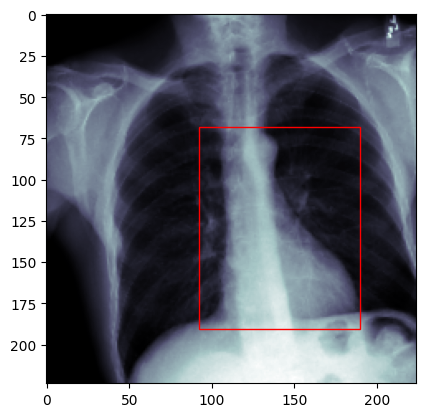

In [6]:
# Getting image at index 15
img, bbox = dataset[0]

fig, axis = plt.subplots(1, 1)
# img[0] because a dimension was added in unsqueeze(0)
# else we would use img
axis.imshow(img[0], cmap='bone')
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='r', facecolor='none')
axis.add_patch(rect)